#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st

#хитмэп корреляции
import os
import seaborn as sns #построение графиков

#операции с выборкой
from sklearn.model_selection import train_test_split

#сохранение модели
import joblib 
from joblib import dump

#классификация
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

#регрессия
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor #создание константной модели (среднее, медиана и др)

#преобразователь масштаба методом стандартизации
from sklearn.preprocessing import StandardScaler

#метрики
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score #кросс-валидация
from sklearn.metrics import make_scorer #для написания ручной оценки

#подбор параметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#построение ROC-кривой
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

#раздел upsampling
from sklearn.utils import shuffle

#библиотека LightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor

#библиотека CatBoost
import catboost as cb
from catboost import CatBoostRegressor

#разложение временного ряда на тренд и сезонную компоненту, построение графиков этих составляющих ряда
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

#замена стандартной кросс-валидации для временных рядов
from sklearn.model_selection import TimeSeriesSplit

#для графиков
import pylab
#plt.style.use('ggplot')

In [2]:
#загрузим датасет
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])   
except FileNotFoundError:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
display(data.head())
display(data.tail())

display(data.describe())

data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
#выполним ресемплирование по одному часу
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Вывод
    данные загружены, столбец дат перенесен в индексы, отсортирован, выполнено ресемплирование

## Анализ

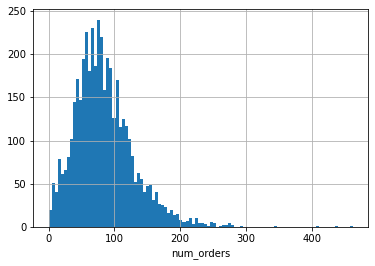

In [5]:
#проверим распределение
plt.figure()
plt.xlabel('num_orders')
data['num_orders'].hist(bins=100)
plt.show()

<AxesSubplot:xlabel='datetime'>

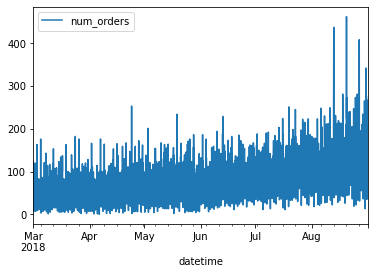

In [6]:
#построим график временного ряда
data.plot()

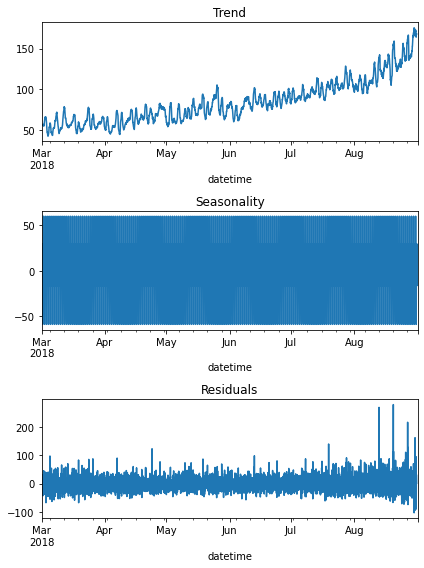

In [7]:
#разложим временной ряд на тренд и сезонную компоненту, построим их графики
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() (англ. get current axis, получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

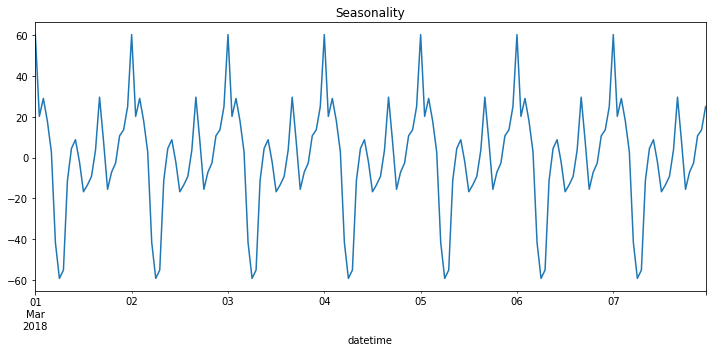

In [8]:
#построим график сезонной составляющей за первые 15 дней данных
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(10, 5))
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() (англ. get current axis, получить текущие оси)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Seasonality')
#plt.subplot(313)
plt.tight_layout()

### Вывод
    проверено распределение, аномалий не выявлено, разложили временной ряд на тренд и сезонную компоненту.

## Обучение

In [9]:
data_raw = data.copy()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
#создадим функцию make_features(), чтобы прибавить к таблице:
# *4 новых календарных признака: год, месяц, день и день недели

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

# *отстающие значения    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

#скользящее среднее        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
make_features(data, 50, 5)

In [12]:
data

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,217.0,216.0,265.0,177.0,170.0,191.0,169.0,120.0,159.0,174.0
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,120.0,174.6
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,182.2


In [13]:
#удалим Nan, создадим выборку
data = data.dropna() 
features = data.drop(['num_orders'], axis=1) 
target = data['num_orders'] 

#Функция train_test_split() из модуля sklearn.model_selection по умолчанию перемешивает данные. 
#Поэтому укажем аргумент shuffle (с англ. «перетасовывать») равным False, чтобы разделить данные корректно.
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=12345)

In [14]:
#убедимся в корректности деления временных диапазонов
print(features_train.index.min(), features_train.index.max())
print(features_test.index.min(), features_test.index.max())

2018-03-03 02:00:00 2018-08-13 18:00:00
2018-08-13 19:00:00 2018-08-31 23:00:00


In [15]:
data

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,2018,3,3,5,108.0,163.0,72.0,119.0,101.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,112.6
2018-03-03 03:00:00,64,2018,3,3,5,25.0,108.0,163.0,72.0,119.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,97.4
2018-03-03 04:00:00,44,2018,3,3,5,64.0,25.0,108.0,163.0,72.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,86.4
2018-03-03 05:00:00,15,2018,3,3,5,44.0,64.0,25.0,108.0,163.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,80.8
2018-03-03 06:00:00,9,2018,3,3,5,15.0,44.0,64.0,25.0,108.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,51.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,217.0,216.0,265.0,177.0,170.0,191.0,169.0,120.0,159.0,174.0
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,120.0,174.6
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,182.2


In [16]:
#проверим корреляцию с созданными признаками
#plt.show()
#plt.figure(figsize = (15, 15))
#sns.heatmap(data.corr(), annot=True, fmt='.2g', square=True, center= 0)

<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано верно.
</div>

#### Константная модель

In [17]:
#оценим модель прогнозом константой. Часовое количество заказов предскажем медианой, 
#сохраним значения в переменной pred_median и найдем для этого прогноза значение RMSE.
#также укажем среднее количество заказов, чтобы соотнести его со значением метрики RMSE.

print("Среднее количество заказов в час:", target_test.mean())
pred_median = np.ones(target_test.shape)*target_train.median()
rmse_const_median = mean_squared_error(target_test, pred_median)**0.5
print("RMSE:", rmse_const_median)

Среднее количество заказов в час: 139.60411899313502
RMSE: 87.35888260909353


In [18]:
#оценим модель предыдущим значением ряда. 

print("Среднее количество заказов в час:", target_test.mean())
pred_previous = target_test.shift() 
pred_previous[0] = target_train.iloc[target_train.shape[0]-1]
rmse_const_previous = mean_squared_error(target_test, pred_previous)**0.5
print("RMSE:", rmse_const_previous)

Среднее количество заказов в час: 139.60411899313502
RMSE: 59.01904048345839


### LinearRegression

In [19]:
%%time

#объявим классификатор не внося параметров
model = LinearRegression()

parametrs = {}

#При работе с временными рядами нельзя использовать стандартную кросс-валидацию, так как в определенный момент тренировочная выборка окажется позже валидационной. Для решения этой проблемы стоит использовать TimeSeriesSplit. Объект этого типа можно передать в параметр cv в метод основанный на кросс-валидации
#Внутри кросс-валидации происходит разбиение переданной в нее выборки на трейн и тест.
tscv = TimeSeriesSplit(n_splits=4, test_size=None) 

#запускаем обучение (n_jobs = -1, использовать все ЦП для обучения, по умолчанию 1 - использовать 1 ЦП)
grid = RandomizedSearchCV(model, parametrs, cv=tscv, n_jobs = 3, 
                          scoring='neg_root_mean_squared_error', verbose=True)
grid.fit(features_train, target_train)

#выводим лучшие параметры
print(grid.best_params_)
print(grid.best_score_)

model = grid.best_estimator_
dump(model, 'LinearRegression.joblib')

Fitting 4 folds for each of 1 candidates, totalling 4 fits


D:\installed\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{}
-24.939621798488265
Wall time: 1.91 s


['LinearRegression.joblib']

### RandomForestRegressor

In [20]:
%%time

#объявим классификатор не внося параметров
model = RandomForestRegressor()

#создаем словарь, в который вписываем параметры, которые будем прогонять GridSearch’ем
#инструмент работает с диапазоном, поэтому поставим random_state (12345, 12346, 10)
parametrs = { 'random_state': range (12345, 12346, 10), 
              'n_estimators': range (3, 5, 1),
              'max_depth': range (1, 5, 2),
              'min_samples_leaf': range (1, 3),
              'min_samples_split': range (2, 5, 1)
            }

tscv = TimeSeriesSplit(n_splits=5, test_size=None)

#запускаем обучение (n_jobs = -1, использовать все ЦП для обучения, по умолчанию 1 - использовать 1 ЦП)
grid = RandomizedSearchCV(model, parametrs, cv=tscv, n_jobs = 3, 
                          scoring='neg_root_mean_squared_error', verbose=True)
grid.fit(features_train, target_train)

#выводим лучшие параметры
print(grid.best_params_)
print(grid.best_score_)

model = grid.best_estimator_
dump(model, 'RandomForestRegressor.joblib')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'random_state': 12345, 'n_estimators': 4, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3}
-28.236838225932303
Wall time: 1.04 s


['RandomForestRegressor.joblib']

### LGBMRegressor

In [21]:
%%time

#объявим классификатор
model = LGBMRegressor(verbosity= -1)

#создаем словарь, в который вписываем параметры, которые будем прогонять GridSearch’ем
#инструмент работает с диапазоном, поэтому поставим random_state (12345, 12346, 10)
parametrs = {'random_state': range (12345, 12346, 10),
             'reg_lambda':[1,3,6],
             'learning_rate':[0.001, 0.01,0.1]                                 
            }

tscv = TimeSeriesSplit(n_splits=5, test_size=None)

#запускаем обучение (n_jobs = -1, использовать все ЦП для обучения, по умолчанию 1 - использовать 1 ЦП)
grid = GridSearchCV(model, parametrs, cv=tscv, n_jobs = 3, scoring='neg_root_mean_squared_error', verbose=3)

grid.fit(features_train, target_train)

#выводим лучшие параметры
print(grid.best_params_)
print(grid.best_score_)

model = grid.best_estimator_
dump(model, 'LGBMRegressor.joblib')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'learning_rate': 0.1, 'random_state': 12345, 'reg_lambda': 6}
-24.220463691682227
Wall time: 5.72 s


['LGBMRegressor.joblib']

### CatBoostRegressor

In [22]:
%%time

#объявим классификатор
model = CatBoostRegressor()

#создаем словарь, в который вписываем параметры, которые будем прогонять GridSearch’ем
#инструмент работает с диапазоном, поэтому поставим random_state (12345, 12346, 10)
parametrs = {'random_state': range (12345, 12346, 10),
             'reg_lambda':[1,3,6],
             'learning_rate':[0.001, 0.01,0.1]                           
            }

tscv = TimeSeriesSplit(n_splits=5, test_size=None)

#запускаем обучение (n_jobs = -1, использовать все ЦП для обучения, по умолчанию 1 - использовать 1 ЦП)
grid = GridSearchCV(model, parametrs, cv=tscv, n_jobs = 3, scoring='neg_root_mean_squared_error', verbose=3)
grid.fit(features_train, target_train)

#выводим лучшие параметры
print(grid.best_params_)
print(grid.best_score_)

model = grid.best_estimator_
dump(model, 'CatBoostRegressor.joblib')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0:	learn: 36.8588330	total: 155ms	remaining: 2m 34s
1:	learn: 35.2035174	total: 167ms	remaining: 1m 23s
2:	learn: 33.7305137	total: 177ms	remaining: 58.7s
3:	learn: 32.4811461	total: 185ms	remaining: 45.9s
4:	learn: 31.3401138	total: 191ms	remaining: 38s
5:	learn: 30.3256765	total: 197ms	remaining: 32.7s
6:	learn: 29.4311593	total: 203ms	remaining: 28.8s
7:	learn: 28.7582130	total: 209ms	remaining: 26s
8:	learn: 28.0732882	total: 216ms	remaining: 23.8s
9:	learn: 27.5392217	total: 223ms	remaining: 22s
10:	learn: 27.0248099	total: 229ms	remaining: 20.6s
11:	learn: 26.5289065	total: 235ms	remaining: 19.4s
12:	learn: 26.1390360	total: 243ms	remaining: 18.4s
13:	learn: 25.7865263	total: 250ms	remaining: 17.6s
14:	learn: 25.4280543	total: 257ms	remaining: 16.8s
15:	learn: 25.1245928	total: 264ms	remaining: 16.2s
16:	learn: 24.8525700	total: 270ms	remaining: 15.6s
17:	learn: 24.6694257	total: 277ms	remaining: 15.1s
18:	learn: 24.4248

['CatBoostRegressor.joblib']

### Вывод
    добавили признаки, удалили пропуски, проверили RMSE константных моделей, GridSearchCV'ем обучили 4 модели.

## Тестирование

### LinearRegression

In [23]:
%%time
model = joblib.load('LinearRegression.joblib')

predicted_test = model.predict(features_test)
rmse_lr = (mean_squared_error(target_test, predicted_test))**0.5
print("RMSE =", rmse_lr)

RMSE = 43.30825114310634
Wall time: 5.07 ms


### RandomForestRegressor

In [24]:
%%time
model = joblib.load('RandomForestRegressor.joblib')

predicted_test = model.predict(features_test)
rmse_rf = (mean_squared_error(target_test, predicted_test))**0.5
print("RMSE =", rmse_rf)

RMSE = 52.484750627485795
Wall time: 12.6 ms


### LGBMRegressor

In [25]:
%%time
model = joblib.load('LGBMRegressor.joblib')

predicted_test = model.predict(features_test)
rmse_lgbm = (mean_squared_error(target_test, predicted_test))**0.5
print("RMSE =", rmse_lgbm)

RMSE = 40.62572880214221
Wall time: 16.5 ms


### CatBoostRegressor

In [26]:
%%time
model = joblib.load('CatBoostRegressor.joblib')

predicted_test = model.predict(features_test)
rmse_catboost = (mean_squared_error(target_test, predicted_test))**0.5
print("RMSE =", rmse_catboost)

RMSE = 39.831265963689745
Wall time: 18.3 ms


### Вывод
    Наименьшее RMSE у CatBoostRegressor

## Общий вывод
    -достигнута цель проекта, получено значение метрики RMSE на тестовой выборке не больше 48
    -наибольшее влиияние на улучшение метрики RMSE оказало увеличение параметра max_lag (до 50, выше - метрика лучше, но скорость обучения ниже) при добавлении признаков с make_features

In [27]:
#результаты
data_rmse = [
    [rmse_const_median, '-', '-'], 
    [rmse_const_previous, '-', '-'],     
    [rmse_lr, '1.92 s', '14.3 ms'],
    [rmse_rf, '897 ms', '14.1 ms'],    
    [rmse_lgbm, '4.61 s', '16.5 ms'],
    [rmse_catboost, '2min 14 s', '19.1 ms'],
    [target_test.mean(), '-', '-']    
]
columns = ['RMSE', '~training time', '~predicting time'] 
regressor = ['Константная модель-медиана', 'Константная модель -предыдущее значеие ряда', 'LinearRegression', 'RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor', "Среднее количество заказов в час:"]

results = pd.DataFrame(data=data_rmse, index=regressor, columns=columns) # создаём таблицу и сохраняем её в переменную

display(results) # выводим таблицу

print('* ~time - время согласно n_jobs (для процессора: 4 ядра (2,8ГГц), 8 потоков) примерно, тк при повторном пересчете - меняется.')

,RMSE,~training time,~predicting time
Константная модель-медиана,87.358883,-,-
Константная модель -предыдущее значеие ряда,59.019040,-,-
LinearRegression,43.308251,1.92 s,14.3 ms
RandomForestRegressor,52.484751,897 ms,14.1 ms
LGBMRegressor,40.625729,4.61 s,16.5 ms
CatBoostRegressor,39.831266,2min 14 s,19.1 ms
Среднее количество заказов в час:,139.604119,-,-


* ~time - время согласно n_jobs (для процессора: 4 ядра (2,8ГГц), 8 потоков) примерно, тк при повторном пересчете - меняется.


In [28]:
model = joblib.load('CatBoostRegressor.joblib')
predicted_test = model.predict(features_test)


graphs = pd.DataFrame(target_test)
graphs['predicted_test'] = predicted_test
graphs2 = graphs

#graphs2 = graphs2.query('index < 20180315')
#graphs2 = graphs2['2018-03-01':'2018-03-15']
#graphs2 = graphs2[graphs2.loc['2018-04-01':'2018-06-15']]

graphs2 = graphs2.loc['2018-08-13':'2018-08-15']

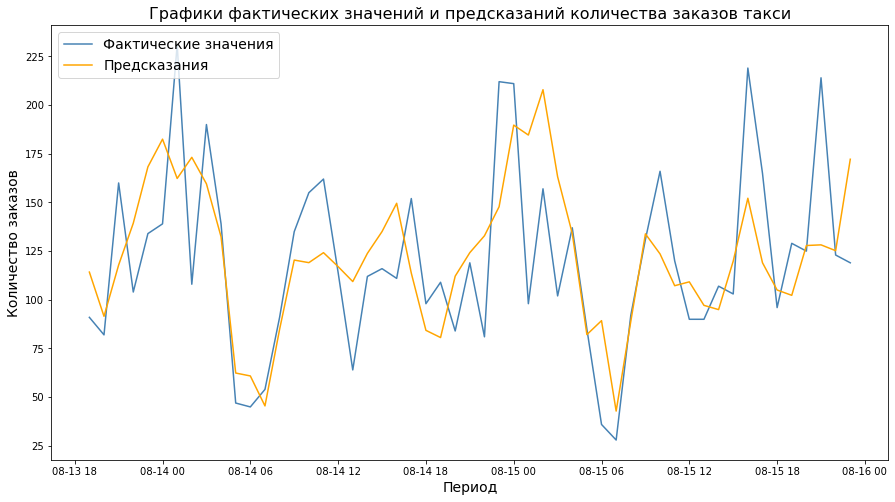

In [29]:
# зададим размер графика
plt.figure(figsize = (15,8))
 
# поочередно зададим кривые (перевозки и скользящее среднее) с подписями и цветом
plt.plot(graphs2['num_orders'], label = 'Фактические значения', color = 'steelblue')
plt.plot(graphs2['predicted_test'], label = 'Предсказания', color = 'orange')
 
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)
 
# добавим подписи к осям и заголовки
plt.ylabel('Количество заказов', fontsize = 14)
plt.xlabel('Период', fontsize = 14)
plt.title('Графики фактических значений и предсказаний количества заказов такси', fontsize = 16)
 
# выведем обе кривые на одном графике
plt.show()

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48